****
**[PARSEME 1.3 MWEs:](https://aclanthology.org/2023.mwe-1.6/)**
****

In [1]:
import conllu
import parseme.cupt as cupt
import os
from tqdm import tqdm
import json

def load_parseme_corpus(path, split="all"):
    if split == "all":
        languages = [lang for lang in os.listdir(path) if os.path.isdir(os.path.join(path, lang))]
    else:
        languages = [split]

    all_data = []  # Renamed to avoid conflict

    for lang in tqdm(languages, desc="Languages", leave=True):
        lang_path = os.path.join(path, lang)

        for split_name in ["train", "test", "dev"]:
            file_path = os.path.join(lang_path, f"{split_name}.cupt")
            if os.path.exists(file_path):
                with open(file_path, "r", encoding="utf-8") as file:
                    file_data = file.read()  # Renamed to file_data
                sentences = conllu.parse(file_data)
                
                for sentence in tqdm(sentences, desc=f"{lang} - {split_name}", leave=False):
                    text = sentence.metadata["text"]
                    mwes = cupt.retrieve_mwes(sentence)
                    mwe_list = []
                    
                    for mwe_id, mwe in mwes.items():
                        if mwe.span:  # Check if the span is not empty
                            start = min(mwe.span)
                            end = max(mwe.span)
                            mwe_words = [
                                token["form"]
                                for token_id, token in enumerate(sentence, start=1)
                                if start <= token_id <= end
                            ]
                            mwe_list.append(" ".join(mwe_words))
                    
                    # Append each sentence as a tuple with text, mwes, and language
                    all_data.append((text, mwe_list, lang))

    return all_data  # Return combined data for all splits and languages

def save_data_to_json(data, output_path):
    # Convert the list of tuples into a list of dictionaries, including language
    json_data = [{"text": text, "mwes": mwe_list, "language": lang} for text, mwe_list, lang in data]
    
    # Save the data to a JSON file with indentation for readability
    with open(output_path, "w", encoding="utf-8") as json_file:
        json.dump(json_data, json_file, indent=4, ensure_ascii=False)

# Usage (example for all languages)
path = "../data/external/parseme1.3"
parseme1_3 = load_parseme_corpus(path, split="all")

# Save the data to a JSON file
output_path = "../data/external/parseme1.3_mwes.json"
save_data_to_json(parseme1_3, output_path)
print(f"Data converted to text-mwes-language JSON format and saved to {output_path}")

Languages: 100%|██████████| 26/26 [02:40<00:00,  6.18s/it]


Data converted to text-mwes-language JSON format and saved to ../data/external/parseme1.3_mwes.json


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Print some statistics
print("Statistics:")

# calculate the number of sentences in the dataset
print(f"Number of sentences in the dataset: {len(parseme1_3)}")

# calculate the total number of MWE expressions in the dataset
print(f"Total number of MWE expressions in this dataset: {len([mwe for _, mwes, _ in parseme1_3 for mwe in mwes])}")

# calculate the percentage of sentences in the dataset with MWEs
print(f"Percentage of sentences with MWEs: {len([1 for _, mwes, _ in parseme1_3 if mwes]) / len(parseme1_3) * 100:.2f}%")

# calculate the average number of MWEs per sentence for sentences with MWEs
mwe_counts = [len(mwes) for _, mwes, _ in parseme1_3 if mwes]
print(f"Average number of MWEs per sentence (if MWEs are present): {sum(mwe_counts) / len(mwe_counts):.2f}")

# check if MWEs occur as a continuous span of tokens
non_contiguous_mwes = len([mwe for _, mwes, _ in parseme1_3 for mwe in mwes]) - sum(mwe in text for text, mwes, _ in parseme1_3 for mwe in mwes if mwes)
print(f"Number of MWEs that don't occur as a continuous span of tokens: {non_contiguous_mwes}")

Statistics:
Number of sentences in the dataset: 455629
Total number of MWE expressions in this dataset: 127498
Percentage of sentences with MWEs: 22.22%
Average number of MWEs per sentence (if MWEs are present): 1.26
Number of MWEs that don't occur as a continuous span of tokens: 14985


In [4]:
# load the data from the JSON file
import json

with open("../data/external/parseme1.3_mwes.json", "r", encoding="utf-8") as file:
    parseme1_3 = json.load(file)

In [5]:
# load the english subset of the data
parseme1_3_en = [item for item in parseme1_3 if item["language"] == "EN"]
# flatten the list of MWEs so that each sentence has one MWE
flattened_parseme1_3_en = []
for item in parseme1_3_en:
    for mwe in item["mwes"]:
        flattened_parseme1_3_en.append({"text": item["text"], "mwe": mwe})
parseme1_3_en = flattened_parseme1_3_en
# print the number of sentences (with or without MWEs) in the English subset
print(f"Number of sentences in the English subset: {len(parseme1_3_en)}")

# extract the unique English MWEs into a list
unique_english_mwes = list(set(item["mwe"] for item in parseme1_3_en))
print(f"Number of unique English MWEs: {len(unique_english_mwes)}")
# sanity check if the MWEs in the English subset exist in their sentences when MWEs are not empty
flagged_items = []
correct = []
for item in parseme1_3_en:
    if item["mwe"]:
        if item["mwe"] not in item["text"]:
            flagged_items.append(item)
        else:
            correct.append(item)
            
print(f"Number of items in the English subset with MWEs not found in the text: {len(flagged_items)}")

Number of sentences in the English subset: 1114
Number of unique English MWEs: 792
Number of items in the English subset with MWEs not found in the text: 21


*There seems to be some MWEs which were tagged incorrected based on the parsing of the data. So, we replace them with the corrected versions with a simple match function:*

In [6]:
from sentence_transformers import SentenceTransformer, util
import re
import torch
import math

# load a pre-trained SentenceTransformer model
model = SentenceTransformer("all-MiniLM-L6-v2")
# load model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# since there seems to be some mismatches based on how the MWEs were extracted and combined, we will use the model to find the most similar MWEs in the text
def find_best_mwe_match(text, mwe):
    # split the text into words
    words = text.split()
    # find n-grams in the text based on the length of the MWE: len(mwe)-5 to len(mwe)
    # for example, if the MWE is "take care of the fellow chickens", then n-grams will be 1-grams to 6-grams, making sure that len(mwe)-5 is not less than 1 and len(mwe) is not more than len(words)
    ngrams = []
    mwe_words = len(mwe.split())
    start = max(1, mwe_words - 5)
    end = min(mwe_words + 1, len(words))

    for n in range(start, end):
        for i in range(len(words) - n + 1):
            ngram = " ".join(words[i:i + n])
            ngrams.append(ngram)
    # find the most similar n-gram to the MWE using the SentenceTransformer model
    ngram_embeddings = model.encode(ngrams, convert_to_tensor=True, device=device)
    mwe_embedding = model.encode(mwe, convert_to_tensor=True, device=device)
    similarities = util.pytorch_cos_sim(ngram_embeddings, mwe_embedding)
    best_match_idx = torch.argmax(similarities).item()
    # if n-gram ends with . or , and mwe doesn't, remove the last character
    if ngrams[best_match_idx].endswith((".", ",")) and not mwe.endswith((".", ",")):
        ngrams[best_match_idx] = ngrams[best_match_idx][:-1]

    # make sure that the n-gram exists in the text
    try:
        start_idx = text.index(ngrams[best_match_idx])
    except ValueError:
        return None
    return ngrams[best_match_idx]

for item in flagged_items:
    match = find_best_mwe_match(item["text"], item["mwe"])
    # replace the MWE with the best match
    if match:
        item["mwe"] = match

# create the new dataset with the corrected MWEs
parseme1_3_en = correct + flagged_items
# print the number of sentences (with or without MWEs) in the English subset
print(f"Number of sentences in the English subset: {len(parseme1_3_en)}")
# extract the unique English MWEs into a list
unique_english_mwes = list(set(item["mwe"] for item in parseme1_3_en))
print(f"Number of unique English MWEs: {len(unique_english_mwes)}")
# sanity check if the MWEs in the English subset exist in their sentences when MWEs are not empty
flagged_items = []
correct = []
for item in parseme1_3_en:
    if item["mwe"]:
        if item["mwe"] not in item["text"]:
            flagged_items.append(item)
        else:
            correct.append(item)
            
print(f"Number of items in the English subset with MWEs not found in the text: {len(flagged_items)}")

Number of sentences in the English subset: 1114
Number of unique English MWEs: 792
Number of items in the English subset with MWEs not found in the text: 0


In [7]:
# add the tag source: parseme1.3 to each item in the dataset
for item in parseme1_3_en:
    item["source"] = "parseme1.3"

# save the corrected English subset to a JSON file
with open("../data/external/parseme1.3_english.json", "w", encoding="utf-8") as file:
    json.dump(parseme1_3_en, file, indent=4, ensure_ascii=False)

print("Corrected English subset saved to ..data/external/parseme1.3_english.json")

Corrected English subset saved to ..data/external/parseme1.3_english.json


****
**[MWE-CWI MWEs:](https://aclanthology.org/2020.lrec-1.545/)**
****

In [9]:
import pandas as pd

# show the full text
pd.set_option("display.max_colwidth", None)

# load the MWE-CWI dataset
with open("../data/external/mwe-cwi.tsv", "r", encoding="utf-8") as file:
    mwe_cwi = pd.read_csv(file, sep="\t")
# keep the columns Index, Expression, Context, Annotation
mwe_cwi = mwe_cwi[["Index", "Expression", "Context", "Annotation"]]
# total number of items
print(f"Total number of items in the MWE-CWI dataset: {len(mwe_cwi)}")
# show the first 5 items
mwe_cwi.head(5)

Total number of items in the MWE-CWI dataset: 4732


,Index,Expression,Context,Annotation
0,0,suspicion of assisting an offender,"A man and woman, both aged 28, arrested on suspicion of assisting an offender were released, without charge, on Saturday evening.",not MWE
1,1,authorities should annul the,"Russian authorities should annul the parliamentary vote results and hold a new election, ex-Soviet leader Mikhail Gorbachev urged Wednesday as popular indignation grew over widespread reports of alleged election fraud.",not MWE
2,2,amnesty for illegal immigrants,"#23-5 He announced his candidacy this past March with a sixteen-page open letter in which he outlined the six pillars of his campaign: amnesty for illegal immigrants, reinstatement of the military draft, a promise to serve only a single presidential term, and calls for tax reform, deficit reduction, and corporate responsibility.",not MWE but contains MWE(s)
3,3,reinstatement of the military draft,"#23-5 He announced his candidacy this past March with a sixteen-page open letter in which he outlined the six pillars of his campaign: amnesty for illegal immigrants, reinstatement of the military draft, a promise to serve only a single presidential term, and calls for tax reform, deficit reduction, and corporate responsibility.",not MWE
4,4,people on board,"#7-12 These include a Boeing 737 en route to Iran, which crashed shortly after take-off in 2008, killing 68 of at least 90 people on board.",not MWE but contains MWE(s)


*We're gonna do some sanity tests here:*

In [10]:
# check if Expression contains [ or ( or { or " without a closing pair
# if so, check if the closing pair is in the Context, i.e. Context = beginning + Expression + ending, and ending[0] = closing pair
# then add the closing pair to the Expression
def add_closing_pair(expression, context):
    flag = False
    beginning = context.split(expression)[0]
    ending = context.split(expression)[1]
    if "[" in expression and "]" not in expression:
        if ending[0] == "]":
            expression += "]"
            flag = True
    if "(" in expression and ")" not in expression:
        if ending[0] == ")":
            expression += ")"
            flag = True
    if "{" in expression and "}" not in expression:
        if ending[0] == "}":
            expression += "}"
            flag = True
    if '"' in expression and '"' not in expression:
        if ending[0] == '"':
            expression += '"'
            flag = True

    return expression, flag

# apply the function to the MWE-CWI dataset
flagged_items = []
for idx, row in mwe_cwi.iterrows():
    expression, flag = add_closing_pair(row["Expression"], row["Context"])
    if flag:
        flagged_items.append(idx)
        mwe_cwi.at[idx, "Expression"] = expression

print(f"Number of items with missing closing pairs: {len(flagged_items)}")

# check if Expression always appears in Context
flagged_items = []
for idx, row in mwe_cwi.iterrows():
    if row["Expression"] not in row["Context"]:
        flagged_items.append(idx)

print(f"Number of items where Expression doesn't appear in Context: {len(flagged_items)}")

# check if Expressions end with punctuation: . or , or ; or : or ! or ?
flagged_items = []
for idx, row in mwe_cwi.iterrows():
    if row["Expression"].endswith((".", ",", ";", ":", "!", "?")):
        flagged_items.append(idx)

print(f"Number of items where Expression ends with punctuation: {len(flagged_items)}")

# check how many Expressions contain , and have "Annotations" as "not MWE but contains MWE (s)"
flagged_items = []
for idx, row in mwe_cwi.iterrows():
    if "," in row["Expression"] and row["Annotation"] == "not MWE but contains MWE (s)":
        flagged_items.append(idx)

print(f"Number of items where Expression contains , and Annotation is 'not MWE but contains MWE (s)': {len(flagged_items)}")

Number of items with missing closing pairs: 7
Number of items where Expression doesn't appear in Context: 0
Number of items where Expression ends with punctuation: 0
Number of items where Expression contains , and Annotation is 'not MWE but contains MWE (s)': 0


In [11]:
# unique Annotations
print(f"The unique annotations are: {list(mwe_cwi["Annotation"].unique())}")
# we're gonna convert the annotations to:
"""
not MWE -> not MWE
not MWE but contains MWE(s) -> not MWE but contains MWE
everything else -> MWE
"""
mwe_cwi["Annotation"] = mwe_cwi["Annotation"].apply(lambda x: "not MWE" if x == "not MWE" else "not MWE but contains MWE" if x == "not MWE but contains MWE(s)" else "MWE")
# unique Annotations after conversion
print(f"The unique annotations after conversion are: {list(mwe_cwi['Annotation'].unique())}")

The unique annotations are: ['not MWE', 'not MWE but contains MWE(s)', 'MW compounds', 'MW named entities', 'fixed phrase', 'PP modifier', 'verb-particle or other phrasal verb', 'semi-fixedVP', 'conjunction/connective', 'verb-preposition', 'coordinated phrase', 'verb-noun(-preposition)', 'support verb']
The unique annotations after conversion are: ['not MWE', 'not MWE but contains MWE', 'MWE']


In [12]:
# distribution of annotations
annotations = mwe_cwi["Annotation"].value_counts()
# convert to dictionary
annotations = annotations.to_dict()
print(f"Annotation distribution: {annotations}")
# number of unique Expressions if annotations are MWE
unique_mwes = mwe_cwi[mwe_cwi['Annotation'] == 'MWE']['Expression'].unique()
print(f"Number of unique Expressions: {len(unique_mwes)}")
# number of 'not MWE but contains MWE' annotations which contain MWEs from the unique_mwes
not_mwe_but_contains_mwe = mwe_cwi[mwe_cwi['Annotation'] == 'not MWE but contains MWE']['Expression']
not_mwe_but_contains_mwe = not_mwe_but_contains_mwe[not_mwe_but_contains_mwe.isin(unique_mwes)]
print(f"Number of 'not MWE but contains MWE' annotations which contain MWEs from the unique Expressions: {len(not_mwe_but_contains_mwe)}")

Annotation distribution: {'not MWE': 2181, 'MWE': 2115, 'not MWE but contains MWE': 436}
Number of unique Expressions: 1636
Number of 'not MWE but contains MWE' annotations which contain MWEs from the unique Expressions: 0


In [13]:
# check how many unique mwes from the MWE-CWI dataset are in the parseme1.3 english: overlap between unique_mwes and unique_english_mwes
overlap = set(unique_mwes) & set(unique_english_mwes)
print(f"Number of unique MWEs in the MWE-CWI dataset that are also in the parseme1.3 English subset: {len(overlap)}")
# number of unique mwes in the MWE-CWI dataset that are not in the parseme1.3 english subset
unique_mwes_mwe_cwi = set(unique_mwes) - set(unique_english_mwes)
print(f"Number of unique MWEs in the MWE-CWI dataset that are not in the parseme1.3 English subset: {len(unique_mwes_mwe_cwi)}")
# number of unique mwes in the parseme1.3 english subset that are not in the MWE-CWI dataset
unique_english_mwes_parseme = set(unique_english_mwes) - set(unique_mwes)
print(f"Number of unique MWEs in the parseme1.3 English subset that are not in the MWE-CWI dataset: {len(unique_english_mwes_parseme)}")

Number of unique MWEs in the MWE-CWI dataset that are also in the parseme1.3 English subset: 13
Number of unique MWEs in the MWE-CWI dataset that are not in the parseme1.3 English subset: 1623
Number of unique MWEs in the parseme1.3 English subset that are not in the MWE-CWI dataset: 779


In [14]:
# find the unique items
unique_items = mwe_cwi["Context"].unique()
# find the duplicates
duplicates = mwe_cwi[mwe_cwi["Context"].duplicated(keep=False)]
# find the unique duplicates
unique_duplicates = duplicates["Context"].unique()
# find all items from the original dataset that match the unique duplicates' contexts
duplicates = mwe_cwi[mwe_cwi["Context"].isin(unique_duplicates)]
print(f"Number of duplicate sentences in the MWE-CWI dataset: {len(duplicates)}")
# check the distribution of the "MWE" vs "Not MWE" vs "Not MWE but contains MWE" vs "MWE" and "not MWE" vs "MWE" and "not MWE but contains MWE" vs "not MWE" and "not MWE but contains MWE" vs "MWE" and "not MWE" and "not MWE but contains MWE"
distribution = {'MWE': 0,
                'not MWE': 0,
                'not MWE but contains MWE': 0,
                'MWE and not MWE': 0,
                'MWE and not MWE but contains MWE': 0,
                'not MWE and not MWE but contains MWE': 0,
                'MWE and not MWE and not MWE but contains MWE': 0}

for context in unique_duplicates:
    # Get all rows with this context
    context_rows = duplicates[duplicates['Context'] == context]
    annotations = sorted(context_rows['Annotation'].unique())
    
    if len(annotations) == 1:
        # If only one type of annotation
        if annotations[0] == 'MWE':
            distribution['MWE'] += 1
        elif annotations[0] == 'not MWE':
            distribution['not MWE'] += 1
        elif annotations[0] == 'not MWE but contains MWE':
            distribution['not MWE but contains MWE'] += 1
    elif len(annotations) == 2:
        # If two types of annotations
        if 'MWE' in annotations and 'not MWE' in annotations:
            distribution['MWE and not MWE'] += 1
        elif 'MWE' in annotations and 'not MWE but contains MWE' in annotations:
            distribution['MWE and not MWE but contains MWE'] += 1
        elif 'not MWE' in annotations and 'not MWE but contains MWE' in annotations:
            distribution['not MWE and not MWE but contains MWE'] += 1
    elif len(annotations) == 3:
        # If all three types of annotations
        distribution['MWE and not MWE and not MWE but contains MWE'] += 1

print()
print("Distribution of annotations in duplicate sentences:")
# Print the distribution
for key, value in distribution.items():
    print(f"{key}: {value}")

Number of duplicate sentences in the MWE-CWI dataset: 4052

Distribution of annotations in duplicate sentences:
MWE: 176
not MWE: 217
not MWE but contains MWE: 2
MWE and not MWE: 541
MWE and not MWE but contains MWE: 116
not MWE and not MWE but contains MWE: 33
MWE and not MWE and not MWE but contains MWE: 170


In [15]:
mwe_cwi.head(5)

,Index,Expression,Context,Annotation
0,0,suspicion of assisting an offender,"A man and woman, both aged 28, arrested on suspicion of assisting an offender were released, without charge, on Saturday evening.",not MWE
1,1,authorities should annul the,"Russian authorities should annul the parliamentary vote results and hold a new election, ex-Soviet leader Mikhail Gorbachev urged Wednesday as popular indignation grew over widespread reports of alleged election fraud.",not MWE
2,2,amnesty for illegal immigrants,"#23-5 He announced his candidacy this past March with a sixteen-page open letter in which he outlined the six pillars of his campaign: amnesty for illegal immigrants, reinstatement of the military draft, a promise to serve only a single presidential term, and calls for tax reform, deficit reduction, and corporate responsibility.",not MWE but contains MWE
3,3,reinstatement of the military draft,"#23-5 He announced his candidacy this past March with a sixteen-page open letter in which he outlined the six pillars of his campaign: amnesty for illegal immigrants, reinstatement of the military draft, a promise to serve only a single presidential term, and calls for tax reform, deficit reduction, and corporate responsibility.",not MWE
4,4,people on board,"#7-12 These include a Boeing 737 en route to Iran, which crashed shortly after take-off in 2008, killing 68 of at least 90 people on board.",not MWE but contains MWE


In [16]:
# convert the MWE-CWI dataset to a json format
dataset = []
for idx, row in mwe_cwi.iterrows():
    dataset.append({"text": row["Context"], "expression": row["Expression"], "annotation": row["Annotation"], "language": "EN", "source": "mwe-cwi"})

# save the MWE-CWI dataset to a JSON file
with open("../data/external/mwe-cwi_english.json", "w", encoding="utf-8") as file:
    json.dump(dataset, file, indent=4, ensure_ascii=False)

****
**[Streusle](https://aclanthology.org/2021.mwe-1.6.pdf)**
****

In [18]:
import json

# Helper function to extract SMWEs and WMWEs from an MWE field
def extract_mwes(mwe):
    smwes = []
    wmwes = []

    # Extract words and their indices
    words = mwe.split()
    smwe_candidates = []
    wmwe_candidates = []

    for word in words:
        # Handle SMWE cases
        if "_" in word:
            smwe_candidates.append(word.replace("_", " "))
        else:
            if smwe_candidates:
                smwes.append(" ".join(smwe_candidates))
                smwe_candidates = []

        # Handle WMWEs cases
        if "~" in word:
            wmwe_candidates.append(word.replace("~", " "))
        else:
            if wmwe_candidates:
                wmwes.append(" ".join(wmwe_candidates))
                wmwe_candidates = []

    # Append any remaining candidates
    if smwe_candidates:
        smwes.append(" ".join(smwe_candidates))
    if wmwe_candidates:
        wmwes.append(" ".join(wmwe_candidates))

    return smwes, wmwes

# Load the data
with open("../data/external/streusle.json", "r", encoding="utf-8") as file:
    streusle = json.load(file)

# Convert the dataset
converted_streusle = []
for item in streusle:
    text = item.get("text", "")
    mwe = item.get("mwe", "")
    smwes, wmwes = extract_mwes(mwe)

    converted_streusle.append({
        "text": text,
        "smwes": smwes,
        "wmwes": wmwes
    })

# Save the converted dataset
with open("../data/external/streusle_english.json", "w", encoding="utf-8") as file:
    json.dump(converted_streusle, file, indent=4, ensure_ascii=False)

print("Dataset converted successfully!")

Dataset converted successfully!


In [20]:
# check how many times the SMWEs and WMWEs appear contiguously in the text
def check_contiguity(text, mwes):
    non_contiguous = 0
    for mwe in mwes:
        if mwe not in text:
            non_contiguous += 1
    return non_contiguous

# load the Streusle dataset
with open("../data/external/streusle_english.json", "r", encoding="utf-8") as file:
    streusle = json.load(file)

# check the contiguity of SMWEs and WMWEs in the Streusle dataset
non_contiguous_smwes = 0
non_contiguous_wmwes = 0
for item in streusle:
    non_contiguous_smwes += check_contiguity(item["text"], item["smwes"])
    non_contiguous_wmwes += check_contiguity(item["text"], item["wmwes"])

print(f"Total number of SMWEs in the Streusle dataset: {sum(len(item['smwes']) for item in streusle)}")
print(f"Number of SMWEs that don't occur as a continuous span of tokens: {non_contiguous_smwes}")
print()
print(f"Total number of WMWEs in the Streusle dataset: {sum(len(item['wmwes']) for item in streusle)}")
print(f"Number of WMWEs that don't occur as a continuous span of tokens: {non_contiguous_wmwes}")

Total number of SMWEs in the Streusle dataset: 3234
Number of SMWEs that don't occur as a continuous span of tokens: 298

Total number of WMWEs in the Streusle dataset: 846
Number of WMWEs that don't occur as a continuous span of tokens: 138


****
**[EPIE Corpus](https://arxiv.org/abs/2006.09479)**
****

****
**Combine the datasets and store them in a single file:**
****

In [ ]:
# store the combined dataset to a file called "../data/corpus/existing_mwes.json"

****
**Joint Statistics:**
****

In [22]:
import json

# load the parseme1.3 English subset
with open("../data/external/parseme1.3_english.json", "r", encoding="utf-8") as file:
    parseme1_3 = json.load(file)

# load the MWE-CWI dataset
with open("../data/external/mwe-cwi_english.json", "r", encoding="utf-8") as file:
    mwe_cwi = json.load(file)

# load the Streusle dataset
with open("../data/external/streusle_english.json", "r", encoding="utf-8") as file:
    streusle = json.load(file)

# extract the unique MWEs from the parseme1.3 English subset
unique_parseme1_3 = set(item["mwe"] for item in parseme1_3)
print(f"Number of unique MWEs in the parseme1.3 English subset: {len(unique_parseme1_3)}")

# extract the unique MWEs from the MWE-CWI dataset
unique_mwes_mwe_cwi = set(item["expression"] for item in mwe_cwi)
print(f"Number of unique MWEs in the MWE-CWI dataset: {len(unique_mwes_mwe_cwi)}")

# extract the unique SMWEs and WMWEs from the Streusle dataset
unique_smwes = set(mwe for item in streusle for mwe in item["smwes"])
unique_wmwes = set(mwe for item in streusle for mwe in item["wmwes"])
unique_mwe_streusle = unique_smwes | unique_wmwes
print(f"Number of unique MWEs in the Streusle dataset: {len(unique_mwe_streusle)}")

Number of unique MWEs in the parseme1.3 English subset: 792
Number of unique MWEs in the MWE-CWI dataset: 3900
Number of unique MWEs in the Streusle dataset: 2802


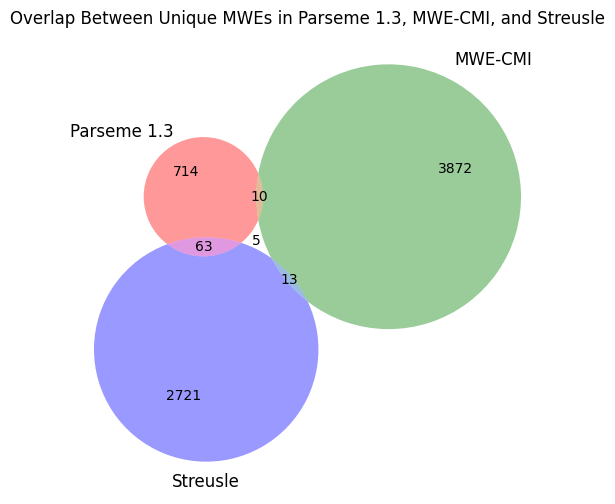

In [23]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

def show_mwe_overlaps(parseme1_3, mwes_mwe_cwi, mwe_streusle):
    """
    Plots a Venn diagram showing the overlap between the unique MWEs 
    in the Parseme 1.3, MWE-CMI, and Streusle datasets.
    
    Args:
    - parseme1_3: Set of unique MWEs from the Parseme 1.3 dataset.
    - mwes_mwe_cwi: Set of unique MWEs from the MWE-CMI dataset.
    - mwe_streusle: Set of unique MWEs from the Streusle dataset.
    """
    # Ensure the inputs are sets
    set_parseme1_3 = set(parseme1_3)
    set_mwes_mwe_cwi = set(mwes_mwe_cwi)
    set_mwe_streusle = set(mwe_streusle)
    
    # Create the Venn diagram
    plt.figure(figsize=(8, 6))
    venn = venn3([set_parseme1_3, set_mwes_mwe_cwi, set_mwe_streusle], 
                 ('Parseme 1.3', 'MWE-CMI', 'Streusle'))
    
    # Customize the diagram (optional)
    plt.title("Overlap Between Unique MWEs in Parseme 1.3, MWE-CMI, and Streusle")
    plt.show()

# Example Usage
show_mwe_overlaps(unique_parseme1_3, unique_mwes_mwe_cwi, unique_mwe_streusle)

In [24]:
# average length of MWEs in the datasets
def average_mwe_length(mwes):
    total_length = sum(len(mwe.split()) for mwe in mwes)
    return round(total_length / len(mwes), 2)

# min and max length of MWEs in the datasets excluding edge cases
def min_max_mwe_length(mwes):
    lengths = [len(mwe.split()) for mwe in mwes]
    # drop the top and bottom 5% of the lengths
    lengths = sorted(lengths)[round(len(lengths) * 0.02):-round(len(lengths) * 0.02)]
    return min(lengths), max(lengths)

# calculate the average length of MWEs in the datasets
average_parseme1_3 = average_mwe_length(unique_parseme1_3)
min_parseme1_3, max_parseme1_3 = min_max_mwe_length(unique_parseme1_3)
print(f"Average length of MWEs in the Parseme 1.3 dataset: {average_parseme1_3}, where the minimum length is {min_parseme1_3} and the maximum length is {max_parseme1_3}")
average_mwe_cwi = average_mwe_length(unique_mwes_mwe_cwi)
min_mwe_cwi, max_mwe_cwi = min_max_mwe_length(unique_mwes_mwe_cwi)
print(f"Average length of MWEs in the MWE-CWI dataset: {average_mwe_cwi}, where the minimum length is {min_mwe_cwi} and the maximum length is {max_mwe_cwi}")
average_streusle = average_mwe_length(unique_mwe_streusle)
min_streusle, max_streusle = min_max_mwe_length(unique_mwe_streusle)
print(f"Average length of MWEs in the Streusle dataset: {average_streusle}, where the minimum length is {min_streusle} and the maximum length is {max_streusle}")

Average length of MWEs in the Parseme 1.3 dataset: 2.91, where the minimum length is 2 and the maximum length is 6
Average length of MWEs in the MWE-CWI dataset: 2.51, where the minimum length is 2 and the maximum length is 5
Average length of MWEs in the Streusle dataset: 2.27, where the minimum length is 1 and the maximum length is 5


****
**[NER Model:](https://huggingface.co/dslim/bert-base-NER)**
<br>
<br>
*Was originally supposed to be this paper: [Automated Concatenation of Embeddings for Structured Prediction](https://github.com/Alibaba-NLP/ACE), but the this one from HuggingFace is a slight improvement on CoNLL 2003, and smaller by size. Easier to use off-the shelf!!*
****

In [25]:
from transformers import pipeline
import transformers

# set the logging to error only
transformers.logging.set_verbosity_error()

# load the NER pipeline 
ner = pipeline("ner", model="dslim/bert-base-NER", tokenizer="dslim/bert-base-NER")

# function that converts the NER results to a list of entities from the BIO format
def extract_entities(ner_results, text):
    # Initialize the entities dictionary
    entities = {
        "PER": [],
        "LOC": [],
        "ORG": [],
        "MISC": []
    }
    
    # Group consecutive tokens with the same entity type
    grouped_entities = []
    current_group = None
    
    for item in ner_results:
        # Extract the base entity type (remove B- or I-)
        entity_type = item['entity'].split('-')[-1]
        
        # Check if this is a subword token
        if item['word'].startswith('##'):
            # If we have a current group and tokens, combine the last token with this subword
            if current_group and current_group['tokens']:
                # Pop the last token and remove '##' from the current token
                last_token = current_group['tokens'].pop()
                current_token = last_token + item['word'].lstrip('##')
                current_group['tokens'].append(current_token)
                
                # Adjust the end index to the full combined token
                current_group['ends'][-1] = item['end']
            continue
        
        # Check if this is the start of a new entity or continuation of existing
        if item['entity'].startswith('B-'):
            # If there's a previous group, add it to the results
            if current_group:
                grouped_entities.append(current_group)
            
            # Start a new group
            current_group = {
                'type': entity_type,
                'tokens': [item['word']],
                'starts': [item['start']],
                'ends': [item['end']]
            }
        elif item['entity'].startswith('I-') and current_group and current_group['type'] == entity_type:
            # Continue the current group
            current_group['tokens'].append(item['word'])
            current_group['starts'].append(item['start'])
            current_group['ends'].append(item['end'])
        else:
            # If current group exists and we're not continuing it, add it to results
            if current_group:
                grouped_entities.append(current_group)
                current_group = None
    
    # Add the last group if it exists
    if current_group:
        grouped_entities.append(current_group)
    
    # Process the grouped entities
    for group in grouped_entities:
        # Reconstruct the entity using the original text
        entity_start = group['starts'][0]
        entity_end = group['ends'][-1]
        
        # Extract the entity string directly from the original text
        entity_string = text[entity_start:entity_end]
        
        # Add to the appropriate entity list
        if entity_string and group['type'] in entities:
            entities[group['type']].append(entity_string)
    
    return entities

# Test case 1
sample1 = "My name is Nishan and I live in Ljubljana, Slovenia. I work at Institute Jožef Stefan at present, and I'm soon moving to La Rochelle, France."
print(extract_entities(ner(sample1), sample1))
print()

# Test case 2
sample2 = "Analysts at Smith and Co., based in London, predict strong growth for Smith Co."
print(extract_entities(ner(sample2), sample2))

{'PER': ['Nishan'], 'LOC': ['Ljubljana', 'Slovenia', 'La Rochelle', 'France'], 'ORG': ['Institute Jožef Stefan'], 'MISC': []}

{'PER': [], 'LOC': ['London'], 'ORG': ['Smith and Co.', 'Smith Co.'], 'MISC': []}
